In [ ]:
#проверка распредения с помощью метода бутстрап и определение стат значимости

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import numpy as np
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')

url = URL(
    user="ABUHTAREVICH",
    password="/",
    account="/",
    warehouse="/",
    database="SEVEREX",
    schema="/",
    #role='xxxxx',
    #authenticator='https://xxxxx.okta.com',
)
engine = create_engine(url)
connection = engine.connect()

query = '''
with main as(SELECT *
FROM 
       events
WHERE 
      install_time::date between '2022-09-12' and '2022-11-03'
        and event_time::date between '2022-09-12' and '2022-11-07'
      and platform = 'android'
      and app_id = 'com.europosit.polygon2d.coloringpuzzle'
      and app_version = '3.0'
      and country_code = 'RU'
      and media_source = 'googleadwords_int'
            ),

rez as(SELECT  m.appsflyer_id
        , s.group_name as group_name
       , sum(m.EVENT_VALUE:revenue::float) as revenue
FROM main m 
        left join (SELECT appsflyer_id
                          , event_value:groupName as group_name
                   FROM main
                   WHERE event_value:testName = 'ab_inter_select'
                         and event_value:groupName in ('ab_inter_manual_360', 'ab_no_inter_auto', 'ab_inter_manual_540')
                    )s on m.appsflyer_id = s.appsflyer_id
where s.group_name is not null
--and revenue is not null
group by 1,2)

SELECT group_name
        ,revenue
FROM rez
where revenue is not null
        
'''


ab_test = pd.read_sql(query, connection)
data_column_1 = ab_test[ab_test.group_name == '"ab_no_inter_auto"'].revenue
data_column_2 = ab_test[ab_test.group_name == '"ab_inter_manual_360"'].revenue
data_column_3 = ab_test[ab_test.group_name == '"ab_inter_manual_540"'].revenue
ab_test

,group_name,revenue
0,"""ab_inter_manual_360""",0.003490
1,"""ab_inter_manual_540""",0.015805
2,"""ab_inter_manual_360""",0.001500
3,"""ab_inter_manual_540""",0.001562
4,"""ab_inter_manual_360""",0.005377
...,...,...
3027,"""ab_no_inter_auto""",0.022863
3028,"""ab_no_inter_auto""",0.017289
3029,"""ab_inter_manual_360""",0.051120
3030,"""ab_inter_manual_540""",0.574538


In [25]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean,
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

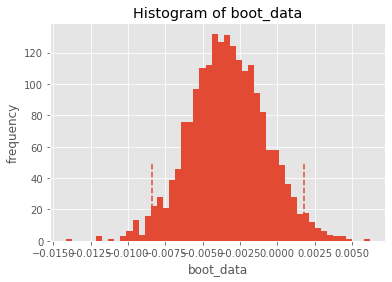

{'ci':               0
 0.025 -0.008400
 0.975  0.001754,
 'p_value': 0.1943740756979645}

In [26]:
get_bootstrap(data_column_1, data_column_2)

  0%|          | 0/2000 [00:00<?, ?it/s]

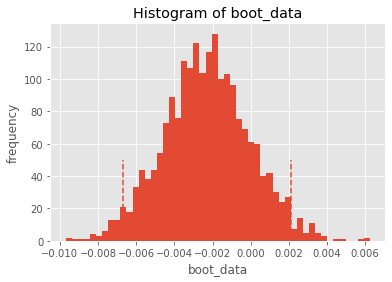

{'ci':               0
 0.025 -0.006701
 0.975  0.002095,
 'p_value': 0.3083037482161043}

In [27]:
get_bootstrap(data_column_1, data_column_3)

In [28]:
mannwhitneyu(data_column_1, data_column_2)

MannwhitneyuResult(statistic=527057.5, pvalue=0.5066225494011554)

In [29]:
mannwhitneyu(data_column_1, data_column_3)

MannwhitneyuResult(statistic=474479.0, pvalue=0.13752843373316873)

In [ ]:
#p-value = 0.3, результаты теста не принимаются, контрольная группа победила